# Прогнозирование количества заказов такси

Разработка модели машинного обучения, способной спрогнозировать количество заказов такси на следующий час на основе исторических данных о заказах такси в аэропортах для компании "Чётенькое такси" с целью привлечения большего числа водителей в период пиковой нагрузки. 

**Ход исследования:**

* Загрузка и подготовка данных к работе;
* Анализ данных;
* Подготовка данных к обучению;
* Обучение моделей:
    * Модель случайного леса `RandomForestRegressor`;
 
    * Модель линейной регрессии `LinearRegression`;
 
    * Модель градиентного бустинга `XGBoost`;
 
    * Модель градиентного бустинга `CatBoost`;
 
    * Модель градиентного бустинга `LightGBM`;
* Итоги исследования.

## Загрузка данных и изучение общей информации

In [1]:
!pip install xgboost

In [2]:
!pip install catboost

In [3]:
# подключение библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

Прочитаем данные из файла `/datasets/taxi.csv` и сразу приведем столбец даты и врмеени к типу `datetime`, установим его в качестве индекса таблицы и отсортируем в хронологическом порядке.

In [4]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемлирование имеющихся данных по одному часу, ссумировав коичество заказов. 

In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Ввывод**

Каждая строка датафрейма содержит инормацию о количестве заказов такси за каждые 10 минут с марта по август 2018 года. После ресемплирования временные периоды стали равны одному часу, а количество заказов в столбце `num_orders` просуммировалось.  Пропусков в таблице нет, а инексы отсортированы. Перейдем к анализу данных.

## Анализ данных

Для начала построим график по имеющимся данным c применением скользящего среднего для снижения интенсивности колебаний и лучшей наглядности графика.

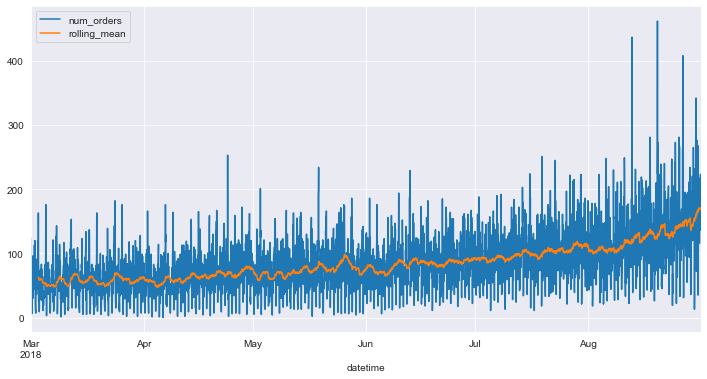

In [7]:
sns.set_style('darkgrid')
df['rolling_mean'] = df.rolling(50).mean()
df.plot(figsize=(12, 6))

df = df.drop(['rolling_mean'], axis=1)

Можно заметить несколько особенно высоких пиков, превышающих 400 заказов в час. Они сконцентрированы в августе и так как в этот период количество заказов в целом несколько выше, чем в остальные месяцы, большие значения, скорее всего, аномалиями не являются.

Рассмотрим тренд и сезонность данных. 

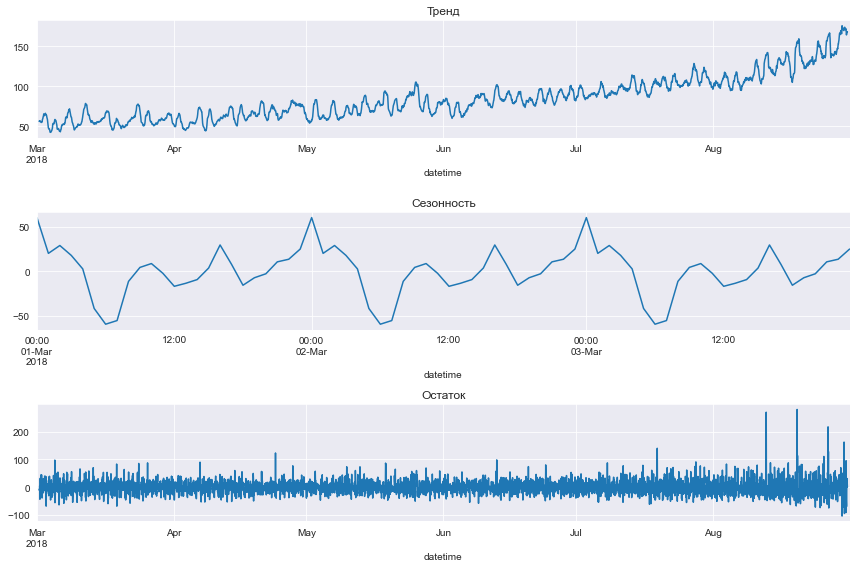

In [8]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

# возьмем трехдневный срез данных для лучшей наглядности графика
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')

plt.tight_layout()

По графику тренда можно заметить повышение количества заказов летом, в особенности в июле и августе, что скорее всего связано с тем, что большинство людей отправляется в отпуск летом, а значит чаще заказывают такси в аэропортах. 

По графику сезонности видна закономерность: ранним утром наблюдается резкий спад в количестве заказов такси и затем в течение дня заказы растут, причем есть выраженные пики заказов утром до 12:00, днем до 18:00 и в полночь - максимальная нагрузка. 

**Вывод:**

В результате анализа данных обнаружили, что распределение заказов со временем меняется: летом среднее значение постепенно повышается. Это указывает на то, что временной ряд является нестационарным, то есть со времнем у такого врмеенного ряда среднее и стандартное отклонение меняются.
Также обнаружена ежедневная сезонность в количестве сделанных заказов такси. 

## Подготовка данных к обучению

Из имеющихся данных создадим признаки для обучения моделей:

* Календарные признаки:
    * Час (т.к. есть суточная сезонность)
    * День недели (т.к. есть недельная сезоннность)
* Отстающие признаки (лаговые переменные =1 и =2, учитывая выставленные календарные признаки)
* Скользязее среднее с окном размером в 24 часа)

In [9]:
def make_features(df, lags, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    df['rolling_mean'] = round(df['num_orders'].shift().rolling(rolling_mean_size).mean())
    
    for lag in lags:
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
make_features(df, [1, 2], 24)

In [10]:
df

,num_orders,hour,day_of_week,rolling_mean,lag_1,lag_2
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,124.0,NaN
2018-03-01 02:00:00,71,2,3,NaN,85.0,124.0
2018-03-01 03:00:00,66,3,3,NaN,71.0,85.0
2018-03-01 04:00:00,43,4,3,NaN,66.0,71.0
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,165.0,207.0,217.0
2018-08-31 20:00:00,154,20,4,168.0,136.0,207.0
2018-08-31 21:00:00,159,21,4,168.0,154.0,136.0


Разделим данные на три выборки: тренировочную, валидационную и тестовую в размере 8:1:1.

In [11]:
train, valid_test = train_test_split(df, shuffle=False, test_size=0.2, random_state=12345)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5, random_state=12345)

train = train.dropna()

train_ft, train_tg = train.drop('num_orders', axis=1), train['num_orders']
valid_ft, valid_tg = valid.drop('num_orders', axis=1), valid['num_orders']
test_ft, test_tg = test.drop('num_orders', axis=1), test['num_orders']

In [12]:
print(f'Размер тренировочной выборки: {train_ft.shape[0]} строк')
print(f'Размер валидационной выборки: {valid_ft.shape[0]} строк')
print(f'Размер тестовой выборки: {test_ft.shape[0]} строк')

Размер тренировочной выборки: 3508 строк
Размер валидационной выборки: 442 строк
Размер тестовой выборки: 442 строк


Приведем признаки к одному масштабу путем стандартизации данных с помощью структуры **StandardScaler**:

In [13]:
numeric = train_ft.columns

scaler = StandardScaler()
scaler.fit(train_ft[numeric])

train_ft[numeric] = scaler.transform(train_ft[numeric])
valid_ft[numeric] = scaler.transform(valid_ft[numeric])
test_ft[numeric] = scaler.transform(test_ft[numeric])

In [14]:
train_ft.head()

,hour,day_of_week,rolling_mean,lag_1,lag_2
datetime,,,,,
2018-03-02 00:00:00,-1.658628,0.498581,-1.049465,-0.459301,1.083033
2018-03-02 01:00:00,-1.514256,0.498581,-1.171364,0.436713,-0.459326
2018-03-02 02:00:00,-1.369884,0.498581,-1.049465,1.276725,0.438046
2018-03-02 03:00:00,-1.225513,0.498581,-1.049465,0.016706,1.279333
2018-03-02 04:00:00,-1.081141,0.498581,-1.049465,-0.291299,0.017403


Оценку качества моделей будем проведить с помощью метрики `RMSE`. Напишем функцию ее расчета:

In [15]:
def rmse_score(target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

**Вывод:**

* Созданы признаки для обучения и удалены пропуски;
* Данные разделены на тренировочную, валидационную и тестовую выборки в размере 8/1/1;
* Признаки во всех выборках приведены к одному масштабу;
* Создана функция расчета метрики качества предсказаний модели `RMSE`

## Обучение моделей

Перед нами стоит задача регрессии, поэтому для обучения выберем следующие модели:

 * Модель случайного леса `RandomForestRegressor`;
 
 * Модель линейной регрессии `LinearRegression`;
 
 * Модель градиентного бустинга `XGBoost`;
 
 * Модель градиентного бустинга `CatBoost`;
 
 * Модель градиентного бустинга `LightGBM`.

Создадим функцию обучения и проверки качества предсказаний:

In [16]:
# функция обучения, предсказания и проверки качества моделей

def fit_predict(regressor, train_ft, train_tg, valid_ft, valid_tg):
    time0 = time.time()
    
    global best_model
    global best_rmse
    global time_fit_pred
    
    model = regressor
    model.fit(train_ft, train_tg)
    predictions = model.predict(valid_ft)
    rmse = rmse_score(valid_tg, predictions)
    
    if rmse < best_rmse:
        best_rmse = round(rmse, 2)
        best_model = model
        
    time_fit_pred = round(time.time() - time0, 4)

### Случайный лес

Для модели случайного леса подберем наилучшие значения глубины дерева и количества деревьев:

In [17]:
best_model, best_rmse = 0, 99999

for est in range(10, 101, 10):
    for depth in range(1, 21):
        fit_predict(RandomForestRegressor(
                    random_state=12345, n_estimators=est, max_depth=depth), 
                       train_ft, train_tg, valid_ft, valid_tg)
        
best_model_forest, best_rmse_forest, time_forest = best_model, best_rmse, time_fit_pred

display(best_model_forest)
print(f'RMSE модели случайного леса: {best_rmse_forest}')
print(f'Скорость обучения и предсказания: {time_forest} минут')

RandomForestRegressor(max_depth=18, n_estimators=90, random_state=12345)

RMSE модели случайного леса: 31.27
Скорость обучения и предсказания: 0.7321 минут


### Линейная регрессия

Теперь обучим модель линейной регрессии:

In [18]:
%%time

best_model, best_rmse = 0, 99999

fit_predict(LinearRegression(), train_ft, train_tg, valid_ft, valid_tg)

best_model_lr, best_rmse_lr, time_lr = best_model, best_rmse, time_fit_pred

display(best_model_lr)
print(f'RMSE модели линейной регрессии: {best_rmse_lr}')
print(f'Скорость обучения и предсказания: {time_lr} минут')

LinearRegression()

RMSE модели линейной регрессии: 41.25
Скорость обучения и предсказания: 0.0227 минут
Wall time: 27.7 ms


### Градиентный бустинг XGBoost

Рассмотрим следующую модель: модель экстремального градиентного бустинга `XGBoost`

In [19]:
# гиперпарметры для модели XGBRegressor

params = {'max_depth': [2, 4, 6, 8], 
         'n_estimators': [100, 200, 300, 400], 
         'learning_rate': [0.1, 0.3, 0.03, 0.5]}

In [20]:
best_model, best_rmse = 0, 99999


for depth in params['max_depth']:
    for est in params['n_estimators']:
        for rate in params['learning_rate']:
            fit_predict(XGBRegressor(
                verbosity=0, n_jobs=-1, random_state=111, booster='gbtree', max_depth=depth, n_estimators=est, 
            learning_rate=rate), train_ft, train_tg, valid_ft, valid_tg)
            
best_model_xgb, best_rmse_xgb, time_xgb = best_model, best_rmse, time_fit_pred
            
display(best_model_xgb)
print(f'RMSE модели градиентного бустинга XGBoost: {best_rmse_xgb}')
print(f'Скорость обучения и предсказания: {time_xgb} минут')

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=111,
             reg_alpha=0, reg_lambda=1, ...)

RMSE модели градиентного бустинга XGBoost: 30.48
Скорость обучения и предсказания: 1.134 минут


### Градиентный бустинг CatBoost

Обучим модель градиентного бустинга `CatBoost`

In [21]:
# гиперпарметры для модели CatBoostRegressor

params = {'iterations': [50, 100, 200], 
         'depth': [2, 4, 6, 8],
         'l2_leaf_reg': [1, 3, 5, 8], 
         'learning_rate':[0.1, 0.3, 0.5]}

In [22]:
best_model, best_rmse = 0, 99999

for i in params['iterations']:
    for depth in params['depth']:
        for leaf in params['l2_leaf_reg']:
            for rate in params['learning_rate']:
                fit_predict(CatBoostRegressor(
                    verbose=0, random_state=12345, loss_function='RMSE', depth=depth, l2_leaf_reg=leaf, 
                    iterations=i, learning_rate=rate), train_ft, train_tg, valid_ft, valid_tg)

best_model_cat, best_rmse_cat, time_cat = best_model, best_rmse, time_fit_pred          

display(best_model_cat.get_params())
print(f'RMSE модели градиентного бустинга CatBoost: {best_rmse_cat}')
print(f'Скорость обучения и предсказания: {time_cat} минут')

{'iterations': 200,
 'learning_rate': 0.3,
 'depth': 8,
 'l2_leaf_reg': 5,
 'loss_function': 'RMSE',
 'verbose': 0,
 'random_state': 12345}

RMSE модели градиентного бустинга CatBoost: 30.74
Скорость обучения и предсказания: 0.7229 минут


### Градиентный бустинг LightGBM

И последняя модель, которую мы рассмотрим: модель градиентного бустинга `LightGBM`

In [23]:
# гиперпарметры для модели LGBMRegressor

params = {'max_depth': [4, 6, 8], 
         'n_estimators': [50, 100, 200, 300], 
         'learning_rate': [0.1, 0.03, 0.3]}

In [24]:
best_model, best_rmse = 0, 99999

for depth in params['max_depth']:
    for est in params['n_estimators']:
        for rate in params['learning_rate']:
            fit_predict(LGBMRegressor(
                random_state=12345, max_depth=depth, n_estimators=est, learning_rate=rate), 
                                                         train_ft, train_tg, valid_ft, valid_tg)
            
best_model_lgbm, best_rmse_lgbm, time_lgbm = best_model, best_rmse, time_fit_pred
            
display(best_model_lgbm)
print(f'RMSE модели градиентного бустинга LightGBM: {best_rmse_lgbm}')
print(f'Скорость обучения и предсказания: {time_lgbm} минут')

LGBMRegressor(learning_rate=0.3, max_depth=4, n_estimators=50,
              random_state=12345)

RMSE модели градиентного бустинга LightGBM: 29.46
Скорость обучения и предсказания: 0.2114 минут


Соберем полученные результаты моделей на валидационной выборке:

In [25]:
result = pd.DataFrame({'Модель': ['RandomForest', 'LinearRegression', 'XGBoost', 'CatBoost', 'LightGBM'], 
             'RMSE valid': [best_rmse_forest, best_rmse_lr, best_rmse_xgb, best_rmse_cat, best_rmse_lgbm], 
             'Скорость обучения и предсказания': [time_forest, time_lr, time_xgb, time_cat, time_lgbm]})

result

,Модель,RMSE valid,Скорость обучения и предсказания
0,RandomForest,31.27,0.7321
1,LinearRegression,41.25,0.0227
2,XGBoost,30.48,1.1340
3,CatBoost,30.74,0.7229
4,LightGBM,29.46,0.2114


**Вывод:**

* Лучшее качество на валидационной выборке показала модель градиентного бустинга `LightGBM`, а по скорости обучения и предсказания оказалась на втором месте.
* Худший показатель `RMSE` показала модель линейной регрессии, но по скорости превзошла все остальные модели.
* Самой медленной моделью стала модель случайного леса. 

## Тестирование моделей

Модели с подобранными гиперпараметрами обучим на объединенной выборке `train_ft` и `valid_ft` для достижения лучших значений метрики `RMSE`. Затем сделаем предсказания для всех моделей на тестовой выборке, выведем графики факт/предсказание для каждой из моделей, а также проверим на вменяемость в сравнении с константной моделью.

In [27]:
train, test = train_test_split(df, shuffle=False, test_size = 0.2, random_state=111)

train = train.dropna()

train_ft, train_tg = train.drop('num_orders', axis=1), train['num_orders']
test_ft, test_tg = test.drop('num_orders', axis=1), test['num_orders']

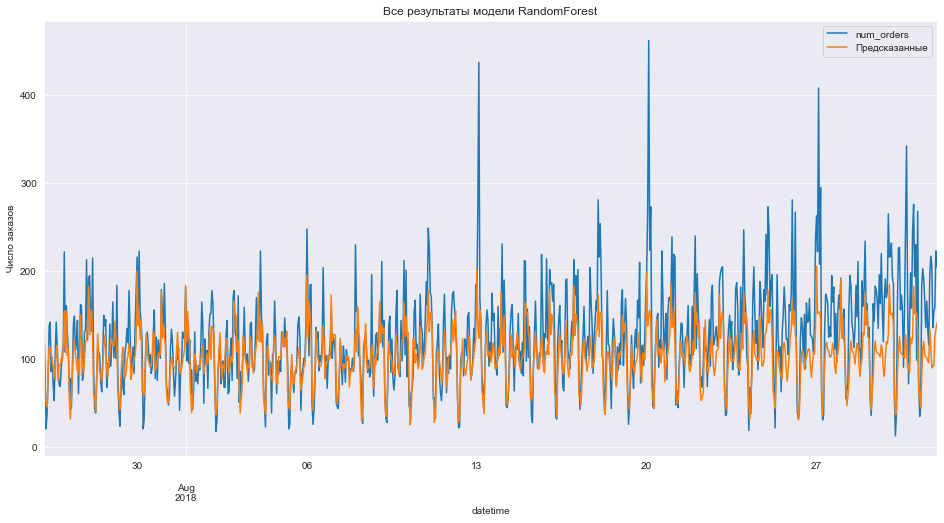

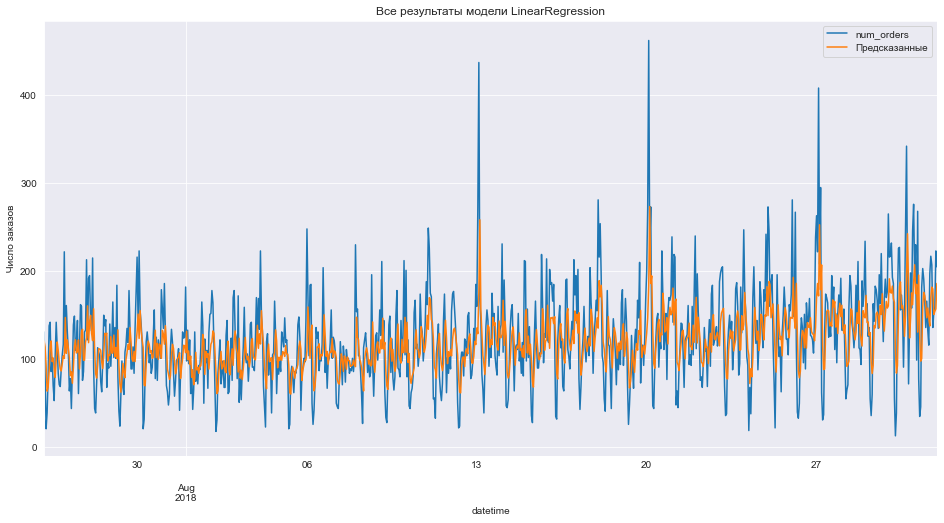

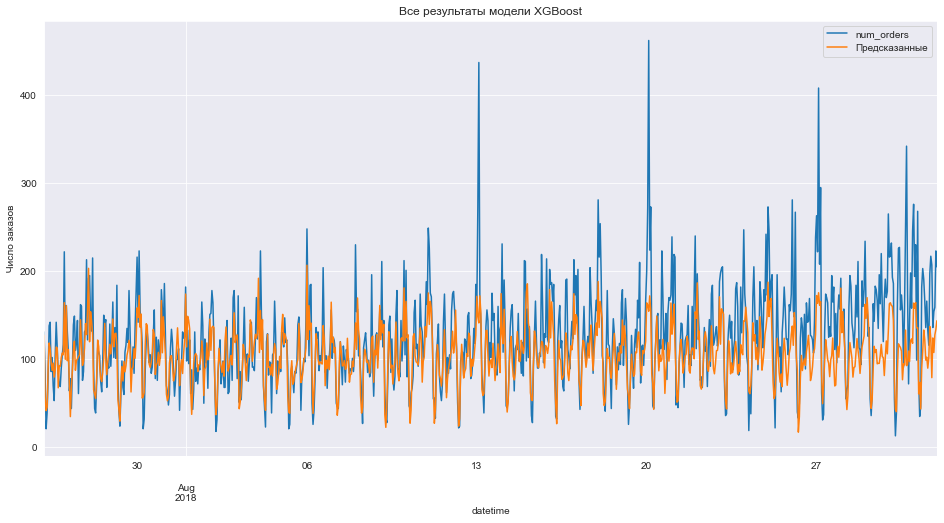

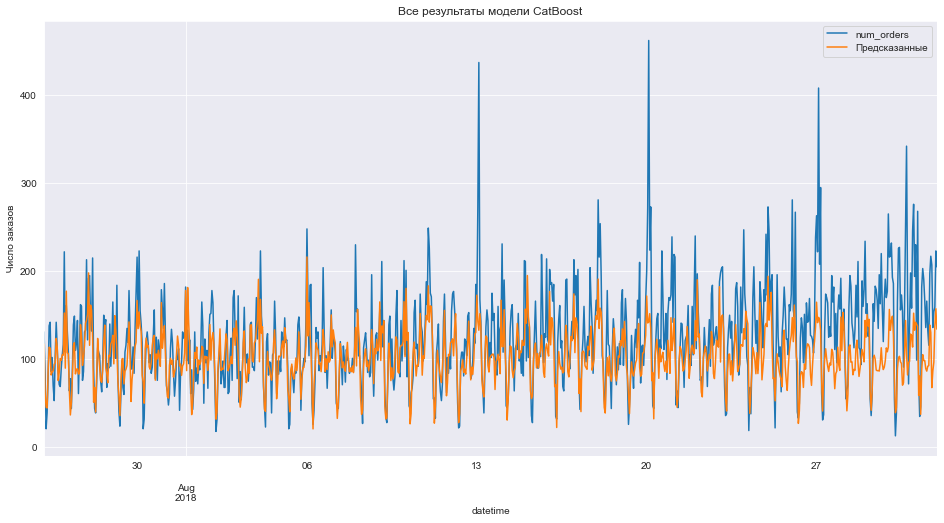

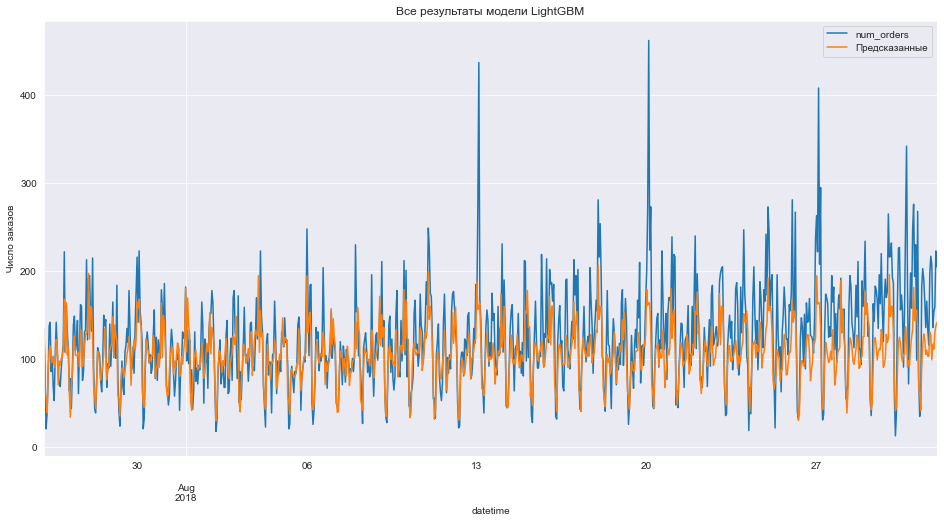

In [28]:
rmse_test = []
test_tg_pd = pd.DataFrame(test_tg)

for model, name in zip([best_model_forest, best_model_lr, best_model_xgb, best_model_cat, best_model_lgbm], ['RandomForest', 'LinearRegression', 'XGBoost', 'CatBoost', 'LightGBM']):
    model = model.fit(train_ft, train_tg)
    
    predictions = model.predict(test_ft)
    rmse = rmse_score(test_tg, predictions)
    rmse_test.append(rmse.round(2))
    
    # вывод графиков факт/предсказание
    test_tg.rename('Реальные', inplace=True)
    pred_pd = pd.DataFrame(predictions, columns=['Предсказанные'], index=test_tg.index)

    pd.concat([test_tg_pd, pred_pd], axis=1).plot(figsize=(16, 8), title=f'Все результаты модели {name}', ylabel='Число заказов')
    

По графикам можно заметить, что ни одна из моделей не справляется с предсказанием выбросов 20, 27 и 30 августа. График предсказаний модели линейной регрессии наиболее близок к графику фактических данных, остальным моделям присущи отклонения от фактического графика к концу августа. 

In [29]:
# проверка результатов константной модели

time0 = time.time()
const_model = DummyRegressor(strategy='mean').fit(train_ft, train_tg)
const_pred_v = const_model.predict(valid_ft)
rmse_const_v = round(rmse_score(valid_tg, const_pred_v), 2)
const_pred_t = const_model.predict(test_ft)
rmse_const_t = round(rmse_score(test_tg, const_pred_t), 2)
time_const = round(time.time() - time0, 2)

rmse_test.append(rmse_const_t)

print(f'RMSE константной модели на валидационной выборке: {rmse_const_v}')
print(f'RMSE константной модели на тестовой выборке: {rmse_const_t}')

RMSE константной модели на валидационной выборке: 58.16
RMSE константной модели на тестовой выборке: 74.34


In [30]:
pd.DataFrame({'Модель': ['RandomForest', 'LinearRegression', 'XGBoost', 'CatBoost', 'LightGBM', 'ConstantModel'], 
             'RMSE valid': [best_rmse_forest, best_rmse_lr, best_rmse_xgb, best_rmse_cat, best_rmse_lgbm, rmse_const_v], 
             'Скорость обучения и предсказания': [time_forest, time_lr, time_xgb, time_cat, time_lgbm, time_const], 
             'RMSE test': rmse_test})

,Модель,RMSE valid,Скорость обучения и предсказания,RMSE test
0,RandomForest,31.27,0.7321,43.48
1,LinearRegression,41.25,0.0227,46.68
2,XGBoost,30.48,1.1340,43.24
3,CatBoost,30.74,0.7229,45.52
4,LightGBM,29.46,0.2114,41.85
5,ConstantModel,58.16,0.0000,74.34


Проверку на адекватность модели прошли.

## Итоги исследования

На тестовой выборке лучший результат качества и скорости показала модель линейной регрессии: `RMSE = 41.85`, а после нее на втором месте оказалась модель градиентного бустинга `LightGBM`, которая ранее показала наилучший результат на валидационной выборке и оказалась на втором месте по скорости обучения и предсказания. 

С задачей прогнозирования количества заказов такси на следующий час лучше всего справилась модель градиентного бустинга `LightGBM`. 